In [1]:
import pickle 
from networkx import draw_networkx_nodes, draw_networkx_edges, draw_networkx
import matplotlib.pyplot as plt
import numpy as np
import copy
import json
import time

In [2]:
training_data_path = 'data/training_data.pkl'
test_data_path = 'data/test_data.pkl'
training_labels_path = 'data/training_labels.pkl'

In [3]:
with open(training_data_path, 'rb') as f :
    training_data = pickle.load(f)

with open(training_labels_path, 'rb') as f :
    training_labels = pickle.load(f)

with open(test_data_path, 'rb') as f :
    test_data = pickle.load(f)

In [4]:
print(type(training_data))
print(len(training_data))

<class 'list'>
6000


### Slight overview on nodes

In [5]:
first_mol = training_data[0]
print(first_mol.nodes)

for atom in first_mol.nodes :
    print(first_mol.nodes[atom]['labels'][0], end='-')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1-1-2-0-0-1-1-1-1-1-1-1-1-1-1-1-

In [6]:
second_mol = training_data[1]
print(second_mol.nodes)

for atom in second_mol.nodes :
    print(second_mol.nodes[atom]['labels'][0], end='-')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
1-1-1-1-2-1-1-1-1-1-1-1-2-2-1-1-1-1-1-1-1-1-1-4-

In [7]:
N_preview = 5

for i in range(N_preview) :
    
    mol = training_data[i]
    print(f'{i}-th molecule composed of {len(mol.nodes)} atoms.')

    for atom in first_mol.nodes :
        print(first_mol.nodes[atom]['labels'][0], end='-')
    print('\n ------------')

0-th molecule composed of 16 atoms.
1-1-2-0-0-1-1-1-1-1-1-1-1-1-1-1-
 ------------
1-th molecule composed of 24 atoms.
1-1-2-0-0-1-1-1-1-1-1-1-1-1-1-1-
 ------------
2-th molecule composed of 18 atoms.
1-1-2-0-0-1-1-1-1-1-1-1-1-1-1-1-
 ------------
3-th molecule composed of 33 atoms.
1-1-2-0-0-1-1-1-1-1-1-1-1-1-1-1-
 ------------
4-th molecule composed of 32 atoms.
1-1-2-0-0-1-1-1-1-1-1-1-1-1-1-1-
 ------------


In [8]:
atom_dict = {k:0 for k in range(50)}


In [9]:
molecule_length = []

for i in range(len(training_data)) :
    
    mol = training_data[i]
    molecule_length.append(len(mol.nodes))

    for atom in mol.nodes :
        atom_type = mol.nodes[atom]['labels'][0]
        atom_dict[atom_type]+=1

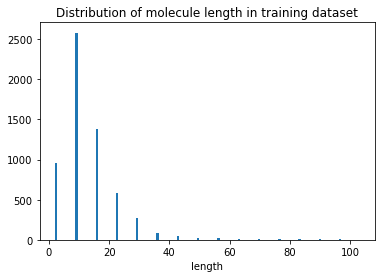

In [10]:
plt.hist(molecule_length, width=0.8, bins=15, align='mid')
plt.title('Distribution of molecule length in training dataset')
plt.xlabel('length')
plt.show()


In [11]:
print(np.mean(molecule_length))
print(np.median(molecule_length))
print(np.quantile(molecule_length, 0.25))
print(np.quantile(molecule_length, 0.75))

16.140333333333334
14.0
10.0
20.0


In [12]:
print(atom_dict)

{0: 15755, 1: 68731, 2: 6900, 3: 1014, 4: 1893, 5: 1316, 6: 277, 7: 98, 8: 293, 9: 106, 10: 0, 11: 25, 12: 36, 13: 239, 14: 1, 15: 7, 16: 8, 17: 20, 18: 1, 19: 6, 20: 0, 21: 11, 22: 3, 23: 2, 24: 3, 25: 1, 26: 3, 27: 4, 28: 38, 29: 0, 30: 1, 31: 5, 32: 9, 33: 7, 34: 3, 35: 1, 36: 1, 37: 4, 38: 1, 39: 4, 40: 1, 41: 3, 42: 1, 43: 1, 44: 3, 45: 2, 46: 1, 47: 1, 48: 1, 49: 1}


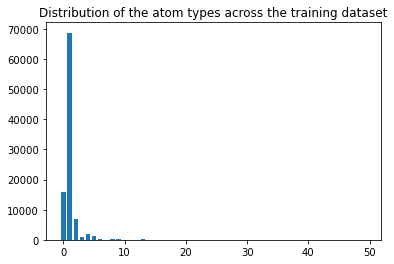

In [13]:
plt.bar(atom_dict.keys(), atom_dict.values(), width= 0.7, align='center')
plt.title('Distribution of the atom types across the training dataset')
plt.show()

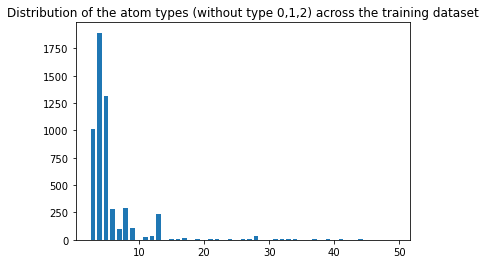

In [14]:
tail_atom_dict = atom_dict
del tail_atom_dict[0]
del tail_atom_dict[1]
del tail_atom_dict[2]
plt.bar(tail_atom_dict.keys(), tail_atom_dict.values(), width= 0.7, align='center')
plt.title('Distribution of the atom types (without type 0,1,2) across the training dataset')
plt.show()

In [15]:
# Check structure of molecule containing atom #47-48-49
for i in range(len(training_data)) :
    
    mol = training_data[i]

    for atom in mol.nodes :
        atom_type = mol.nodes[atom]['labels'][0]
        if atom_type in [47,48,49] :
            for atom in mol.nodes :
                print(mol.nodes[atom]['labels'][0], end='-')
            print('\n')

47-4-4-4-

0-48-0-0-

1-1-1-1-1-1-4-49-



### Slight overview on edges

In [16]:
edges_dict = {k:0 for k in range(4)}

for i in range(len(training_data)) :
    
    mol = training_data[i]
    mol_length = len(mol.nodes)

    edge_list = [(i,j) for i in range(mol_length) for j in range(i+1, mol_length)]

    number_error = 0

    for edge in edge_list :
            try :
                edge_type = mol.edges[edge[0],edge[1]]['labels'][0]
                # edges_dict[edge_type] = edges_dict.get(edge_type, 0) + 1
                edges_dict[edge_type] += 1
            except KeyError as e :
                number_error += 1

print(edges_dict)
print(number_error)

{0: 60228, 1: 8812, 2: 28308, 3: 238}
77


In [17]:
print(f'In the training set, {100*number_error/(sum(edges_dict.values())+number_error):.3f}% of atom bonds do not exist')

In the training set, 0.079% of atom bonds do not exist


### Discovering labels of training data

In [18]:
print(type(training_labels))
print(len(training_labels))
print(set(training_labels))

<class 'numpy.ndarray'>
6000
{0, 1}


In [19]:
print(f"{np.sum(training_labels)}/{len(training_labels)} are positive graphs.")

555/6000 are positive graphs.


In [20]:
def get_all_atom_types(G) :

    atom_types = {}
    for k in G.nodes :
        atom_types[k] = G.nodes[k]['labels'][0]

    return atom_types


def get_atom_type(G, vertex_id) :

    return G.nodes[vertex_id]['labels'][0]



def get_neighbors_id(G, vertex_id) :

    L = []
    neighbored_edges = [k for k in G.edges if vertex_id in k]

    for edge in neighbored_edges :

        if edge[0] != vertex_id :
            L.append(edge[0])
        else : 
            L.append(edge[1])

    return L


def sorted_neighbors_id(G, vertex_id, pattern_dict) :

    """ 
    Returns a dict {neighbors id: neighbors label} sorted by their label

    """
    # Define random but fixed order for labels
    unique_pattern_order = list(pattern_dict.keys())

    # Get a dict of neighbors_id with their label and order it according to the label order ahead
    neighbors_id = get_neighbors_id(G, vertex_id)
    neighbors_dict = {k:str(get_atom_type(G,k)) for k in neighbors_id}

    neighbors_dict_sorted = dict(sorted(neighbors_dict.items(), key=lambda item: unique_pattern_order.index(item[1])))

    return neighbors_dict_sorted


def WL(Graph, max_iter, verbose=False) :

    G = copy.deepcopy(Graph)

    
    feature_vector = {}

    # Initialize feature vector with initial labels
    atom_types = get_all_atom_types(G)
    atom_types_set = set(atom_types.values())

    pattern_dict = {str(pattern):list(atom_types.values()).count(pattern) for pattern in atom_types_set}
    old_pattern_dict_length = len(pattern_dict)
    feature_vector.update(pattern_dict)

    if verbose : 
        print('Pattern dict', pattern_dict)

    # Start iterations
    for iter in range(1, max_iter+1) :
        
        pattern_type = [] 

        for vertex_id in G.nodes :
            
            # Get vertex label
            vertex_type = get_atom_type(G, vertex_id)
            
            # Identify neighbors of current vertex
            neighbors_id = sorted_neighbors_id(G, vertex_id, pattern_dict)
            
            # Identify patterns and fill exhaustively pattern list (with potentially repetition)
            pattern = f'{vertex_type}' + iter*'-' + '>'
            for neighbor in neighbors_id :
                pattern += str(get_atom_type(G, neighbor))
                pattern += (iter-1)*' '
            
            pattern_type.append(pattern)

        for k in range(len(pattern_type)) :

            # Change vertex label (relabelling)
            G.nodes[k]['labels'][0] = pattern_type[k]

        # Count unique patterns  
        pattern_dict = {k:pattern_type.count(k) for k in set(pattern_type)}
        assert sum(pattern_dict.values()) == len(G.nodes)
        
  
        # Stop algorithm if iteration doesn't add information
        if len(pattern_dict) == old_pattern_dict_length :
            break
        else :
            old_pattern_dict_length = len(pattern_dict)
            # Update feature vector
            feature_vector.update(pattern_dict)  
        
        if verbose :
            print(f'Iteration {iter} finished !')
            print('Pattern dict', pattern_dict)
            print('Length of pattern dict', len(pattern_dict))
            print('Feature_vector', feature_vector)

    return feature_vector


def liner_kernel(fv1, fv2) :

    """
    Given two WL embeddings of graph, compute their similarity as the dot product (hence linear kernel)
    ! WARNING ! : only the common patterns are taken into account for this dot product.

    """
    s = 0
    for k in fv1 : 
        if k in fv2 : 
            s += fv1[k]*fv2[k]
    
    return s

In [21]:
print(WL(training_data[0], 10, verbose=True))

Pattern dict {'0': 2, '1': 13, '2': 1}
Iteration 1 finished !
Pattern dict {'2->111': 1, '1->11': 4, '1->011': 2, '1->12': 3, '0->11': 2, '1->1': 2, '1->01': 1, '1->0': 1}
Length of pattern dict 8
Feature_vector {'0': 2, '1': 13, '2': 1, '2->111': 1, '1->11': 4, '1->011': 2, '1->12': 3, '0->11': 2, '1->1': 2, '1->01': 1, '1->0': 1}
Iteration 2 finished !
Pattern dict {'1->011-->1->11 1->011 0->11 ': 2, '1->1-->1->12 ': 2, '1->01-->1->12 0->11 ': 1, '1->11-->1->11 1->011 ': 2, '1->12-->2->111 1->1 ': 2, '1->11-->1->11 1->11 ': 2, '1->12-->2->111 1->01 ': 1, '0->11-->1->011 1->01 ': 1, '2->111-->1->12 1->12 1->12 ': 1, '1->0-->0->11 ': 1, '0->11-->1->011 1->0 ': 1}
Length of pattern dict 11
Feature_vector {'0': 2, '1': 13, '2': 1, '2->111': 1, '1->11': 4, '1->011': 2, '1->12': 3, '0->11': 2, '1->1': 2, '1->01': 1, '1->0': 1, '1->011-->1->11 1->011 0->11 ': 2, '1->1-->1->12 ': 2, '1->01-->1->12 0->11 ': 1, '1->11-->1->11 1->011 ': 2, '1->12-->2->111 1->1 ': 2, '1->11-->1->11 1->11 ': 2, '

In [22]:
mol_id = 10
embedding = WL(training_data[mol_id], 10)
print(json.dumps(embedding, indent=1))

{
 "0": 8,
 "1": 16,
 "2": 3,
 "1->0111": 1,
 "0->1": 8,
 "1->022": 1,
 "2->111": 3,
 "1->11": 2,
 "1->12": 6,
 "1->2": 1,
 "1->1": 2,
 "1->001": 3,
 "0->1-->1->0111 ": 1,
 "2->111-->1->12 1->12 1->2 ": 1,
 "1->022-->0->1 2->111 2->111 ": 1,
 "2->111-->1->022 1->12 1->12 ": 2,
 "1->12-->2->111 1->1 ": 2,
 "1->12-->2->111 1->12 ": 4,
 "1->0111-->0->1 1->11 1->11 1->001 ": 1,
 "1->11-->1->0111 1->001 ": 2,
 "1->001-->0->1 0->1 1->11 ": 2,
 "0->1-->1->022 ": 1,
 "1->2-->2->111 ": 1,
 "1->1-->1->12 ": 2,
 "1->001-->1->0111 0->1 0->1 ": 1,
 "0->1-->1->001 ": 6,
 "2->111-->1->022 1->12 1->12 --->1->022-->0->1 2->111 2->111   1->12-->2->111 1->1   1->12-->2->111 1->1   ": 1,
 "1->1-->1->12 --->1->12-->2->111 1->1   ": 2,
 "0->1-->1->022 --->1->022-->0->1 2->111 2->111   ": 1,
 "1->11-->1->0111 1->001 --->1->0111-->0->1 1->11 1->11 1->001   1->001-->0->1 0->1 1->11   ": 2,
 "0->1-->1->001 --->1->001-->1->0111 0->1 0->1   ": 2,
 "1->12-->2->111 1->1 --->2->111-->1->022 1->12 1->12   1->1-->1->1

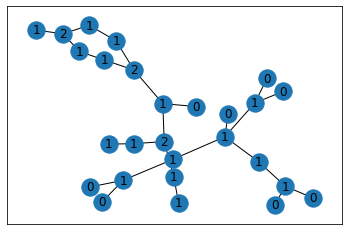

In [23]:
draw_networkx(training_data[mol_id], labels=get_all_atom_types(training_data[mol_id]))

In [24]:
N = 100
gram = np.zeros((N,N))
fv = []

start = time.time()
for k in range(N) :
    fv.append(WL(training_data[k], max_iter=5))

for i in range(N) :
    for j in range(i, N) :
        gram[i,j] = liner_kernel(fv[i],fv[j])

end = time.time()

print(gram)
print(end-start)

[[ 306.  322.  213. ...  325.  607.  767.]
 [   0.  678.  328. ...  566. 1091. 1330.]
 [   0.    0.  248. ...  330.  582.  759.]
 ...
 [   0.    0.    0. ...  675. 1043. 1381.]
 [   0.    0.    0. ...    0. 2436. 2558.]
 [   0.    0.    0. ...    0.    0. 3666.]]
0.3633239269256592
